# Importing Libraries

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Sklearn

In [2]:
from sklearn.model_selection import train_test_split

# TensorFlow

In [22]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import load_model
#tf.compat.v1.enable_eager_execution()
# import segmentation_models as sm

2.13.0


# wandb

In [4]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [5]:
wandb.init(project='unet_using_tf')

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Data path

In [6]:
DATA_PATH = '/kaggle/input/landcoverai'

# Sample visulization

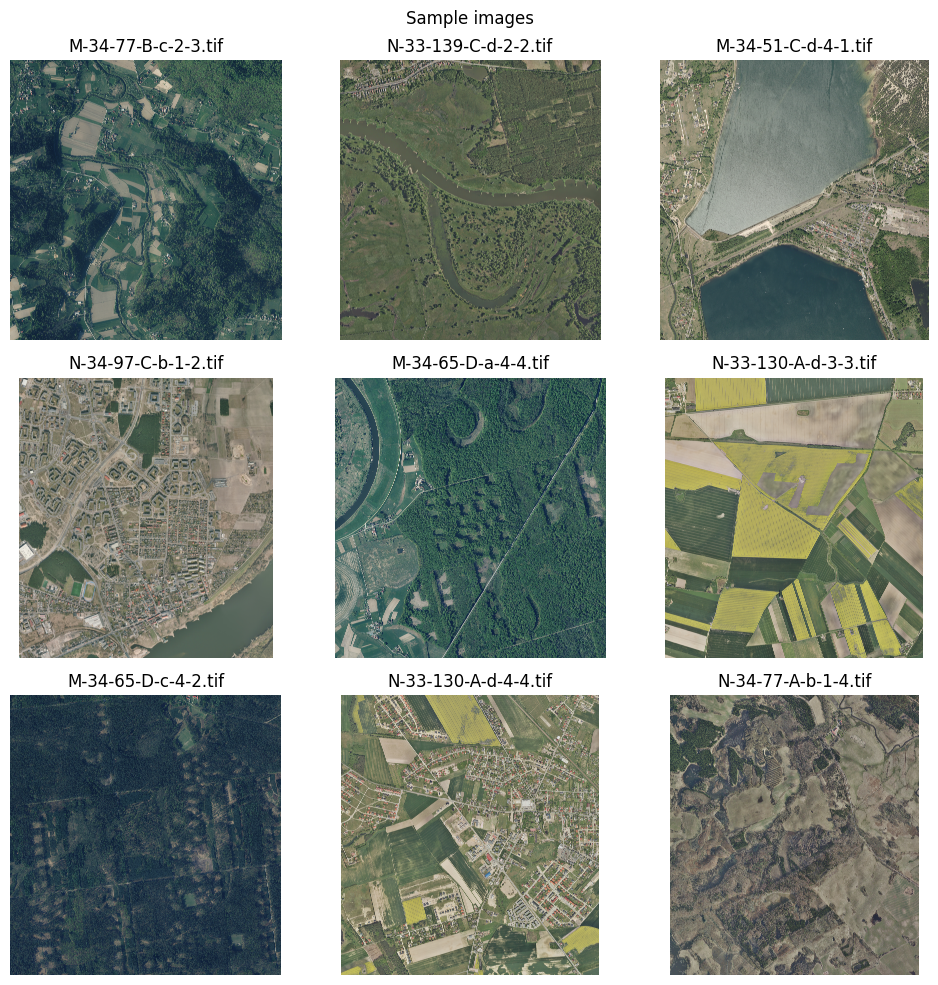

In [7]:
image_lst = os.listdir(os.path.join(DATA_PATH, 'images'))
fig, ax = plt.subplots(3,3, figsize=(10,10))
for i, image_name in enumerate(image_lst[:9]):
    image_path = os.path.join(DATA_PATH, 'images', image_name)
    image = cv2.imread(image_path)
    image = image[:,:,::-1]
    ax[i // 3, i % 3].imshow(image)
    ax[i // 3, i % 3].axis('off')
    ax[i // 3, i % 3].set_title(image_name)
plt.suptitle('Sample images')
plt.tight_layout()
plt.show()

# Spliting images and masks

In [8]:
def load_data(path):
    images = []
    annotations = []
    
    width = 512
    height = 512

    image_files = os.listdir(os.path.join(path, 'images'))
    annotation_files = os.listdir(os.path.join(path, 'masks'))

    for img_name, annot_name in zip(image_files, annotation_files):
        img_path = os.path.join(path, 'images', img_name)
        annot_path = os.path.join(path, 'masks', annot_name)

        img = cv2.imread(img_path)
        img = cv2.resize(img, (width, height))  # Resize image to a specific size
        images.append(img)

        annot = cv2.imread(annot_path)
        annot = cv2.resize(annot, (width, height))  # Resize annotation to the same size as the image
        annotations.append(annot)

    return np.array(images), np.array(annotations)


In [9]:
image, annotations = load_data(DATA_PATH)

# Train test spliting

In [10]:
images_train, images_test, masks_train, masks_test = train_test_split(image, annotations, test_size=0.2, random_state=42)

# Unet Architecture 

In [11]:
def conv_block(input, num_filters):
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(input)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation('relu')(conv)
    conv = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation('relu')(conv)
    return conv

In [12]:
def encoder_block(input, num_filters):
    skip = conv_block(input, num_filters)
    pool = tf.keras.layers.MaxPool2D((2,2))(skip)
    return skip, pool

In [13]:
def decoder_block(input, skip, num_filters):
    up_conv = tf.keras.layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(input)
    conv = tf.keras.layers.Concatenate()([up_conv, skip])
    conv = conv_block(conv, num_filters)
    return conv

In [14]:
def Unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)

    skip1, pool1 = encoder_block(inputs, 64)
    skip2, pool2 = encoder_block(pool1, 128)
    skip3, pool3 = encoder_block(pool2, 256)
    skip4, pool4 = encoder_block(pool3, 512)

    bridge = conv_block(pool4, 1024)

    decode1 = decoder_block(bridge, skip4, 512)
    decode2 = decoder_block(decode1, skip3, 256)
    decode3 = decoder_block(decode2, skip2, 128)
    decode4 = decoder_block(decode3, skip1, 64)

    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation="softmax")(decode4) #####

    model = tf.keras.models.Model(inputs, outputs, name="U-Net")
    return model

## Model compile 

In [15]:
unet_model = Unet((512,512,3))
unet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Model summary 

In [16]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 512, 512, 64)         0         ['batch_normalization[0][0

In [17]:
image[0].shape

(512, 512, 3)

# Model training 

In [18]:
unet_results = unet_model.fit(images_train, masks_train, validation_split=0.2, batch_size=4, epochs=50,callbacks=[
        WandbMetricsLogger(log_freq=5),
        WandbModelCheckpoint("models"),
    ])

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 3.9633 - accuracy: 0.7359

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 79s 5s/step - loss: 3.9633 - accuracy: 0.7359 - val_loss: 6201.0000 - val_accuracy: 0.2527
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 3.6345 - accuracy: 0.9061

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.6345 - accuracy: 0.9061 - val_loss: 610919.6875 - val_accuracy: 0.4977
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 3.6547 - accuracy: 0.8617

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.6547 - accuracy: 0.8617 - val_loss: 34541.6836 - val_accuracy: 0.1336
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 3.7192 - accuracy: 0.9517

wandb: Adding directory to artifact (./models)... Done. 1.9s


7/7 [==============================] - 18s 3s/step - loss: 3.7192 - accuracy: 0.9517 - val_loss: 3342.3420 - val_accuracy: 0.0018
Epoch 5/50
7/7 [==============================] - ETA: 0s - loss: 3.7283 - accuracy: 0.9608

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.7283 - accuracy: 0.9608 - val_loss: 317.3437 - val_accuracy: 0.7740
Epoch 6/50
7/7 [==============================] - ETA: 0s - loss: 3.6651 - accuracy: 0.9702

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.6651 - accuracy: 0.9702 - val_loss: 1865814.6250 - val_accuracy: 0.9985
Epoch 7/50
7/7 [==============================] - ETA: 0s - loss: 3.6583 - accuracy: 0.9606

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.6583 - accuracy: 0.9606 - val_loss: 171425.7188 - val_accuracy: 0.7529
Epoch 8/50
7/7 [==============================] - ETA: 0s - loss: 3.6753 - accuracy: 0.9282

wandb: Adding directory to artifact (./models)... Done. 4.0s


7/7 [==============================] - 21s 3s/step - loss: 3.6753 - accuracy: 0.9282 - val_loss: 90540.4844 - val_accuracy: 0.7465
Epoch 9/50
7/7 [==============================] - ETA: 0s - loss: 3.6909 - accuracy: 0.8899

wandb: Adding directory to artifact (./models)... Done. 1.4s


7/7 [==============================] - 18s 3s/step - loss: 3.6909 - accuracy: 0.8899 - val_loss: 6207.2632 - val_accuracy: 0.8513
Epoch 10/50
7/7 [==============================] - ETA: 0s - loss: 3.7165 - accuracy: 0.8737

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.7165 - accuracy: 0.8737 - val_loss: 39.7638 - val_accuracy: 0.8764
Epoch 11/50
7/7 [==============================] - ETA: 0s - loss: 3.7393 - accuracy: 0.8315

wandb: Adding directory to artifact (./models)... Done. 1.4s


7/7 [==============================] - 19s 3s/step - loss: 3.7393 - accuracy: 0.8315 - val_loss: 9.5950 - val_accuracy: 0.9952
Epoch 12/50
7/7 [==============================] - ETA: 0s - loss: 3.7785 - accuracy: 0.7755

wandb: Adding directory to artifact (./models)... Done. 1.4s


7/7 [==============================] - 18s 3s/step - loss: 3.7785 - accuracy: 0.7755 - val_loss: 3.7563 - val_accuracy: 0.9924
Epoch 13/50
7/7 [==============================] - ETA: 0s - loss: 3.8103 - accuracy: 0.6479

wandb: Adding directory to artifact (./models)... Done. 3.0s


7/7 [==============================] - 20s 3s/step - loss: 3.8103 - accuracy: 0.6479 - val_loss: 3.7096 - val_accuracy: 0.9937
Epoch 14/50
7/7 [==============================] - ETA: 0s - loss: 3.8586 - accuracy: 0.5840

wandb: Adding directory to artifact (./models)... Done. 1.4s


7/7 [==============================] - 18s 3s/step - loss: 3.8586 - accuracy: 0.5840 - val_loss: 3.6306 - val_accuracy: 0.9947
Epoch 15/50
7/7 [==============================] - ETA: 0s - loss: 3.8497 - accuracy: 0.5994

wandb: Adding directory to artifact (./models)... Done. 2.3s


7/7 [==============================] - 20s 3s/step - loss: 3.8497 - accuracy: 0.5994 - val_loss: 3.5265 - val_accuracy: 0.8485
Epoch 16/50
7/7 [==============================] - ETA: 0s - loss: 3.8378 - accuracy: 0.5758

wandb: Adding directory to artifact (./models)... Done. 1.7s


7/7 [==============================] - 19s 3s/step - loss: 3.8378 - accuracy: 0.5758 - val_loss: 3.5398 - val_accuracy: 0.8290
Epoch 17/50
7/7 [==============================] - ETA: 0s - loss: 3.8765 - accuracy: 0.5138

wandb: Adding directory to artifact (./models)... Done. 1.4s


7/7 [==============================] - 18s 3s/step - loss: 3.8765 - accuracy: 0.5138 - val_loss: 3.5577 - val_accuracy: 0.8937
Epoch 18/50
7/7 [==============================] - ETA: 0s - loss: 3.8514 - accuracy: 0.5354

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 19s 3s/step - loss: 3.8514 - accuracy: 0.5354 - val_loss: 3.5346 - val_accuracy: 0.9358
Epoch 19/50
7/7 [==============================] - ETA: 0s - loss: 3.8518 - accuracy: 0.4958

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.8518 - accuracy: 0.4958 - val_loss: 3.5382 - val_accuracy: 0.7111
Epoch 20/50
7/7 [==============================] - ETA: 0s - loss: 3.8261 - accuracy: 0.5132

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.8261 - accuracy: 0.5132 - val_loss: 3.5581 - val_accuracy: 0.5274
Epoch 21/50
7/7 [==============================] - ETA: 0s - loss: 3.8879 - accuracy: 0.4935

wandb: Adding directory to artifact (./models)... Done. 1.6s


7/7 [==============================] - 19s 3s/step - loss: 3.8879 - accuracy: 0.4935 - val_loss: 7.5955 - val_accuracy: 0.5652
Epoch 22/50
7/7 [==============================] - ETA: 0s - loss: 3.8546 - accuracy: 0.4730

wandb: Adding directory to artifact (./models)... Done. 1.6s


7/7 [==============================] - 18s 3s/step - loss: 3.8546 - accuracy: 0.4730 - val_loss: 5.6831 - val_accuracy: 0.6015
Epoch 23/50
7/7 [==============================] - ETA: 0s - loss: 3.8232 - accuracy: 0.5114

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 19s 3s/step - loss: 3.8232 - accuracy: 0.5114 - val_loss: 5.9697 - val_accuracy: 0.7602
Epoch 24/50
7/7 [==============================] - ETA: 0s - loss: 3.8724 - accuracy: 0.4757

wandb: Adding directory to artifact (./models)... Done. 1.6s


7/7 [==============================] - 18s 3s/step - loss: 3.8724 - accuracy: 0.4757 - val_loss: 6.2101 - val_accuracy: 0.2160
Epoch 25/50
7/7 [==============================] - ETA: 0s - loss: 3.8605 - accuracy: 0.4687

wandb: Adding directory to artifact (./models)... Done. 1.6s


7/7 [==============================] - 19s 3s/step - loss: 3.8605 - accuracy: 0.4687 - val_loss: 6.5330 - val_accuracy: 0.5197
Epoch 26/50
7/7 [==============================] - ETA: 0s - loss: 3.8338 - accuracy: 0.4998

wandb: Adding directory to artifact (./models)... Done. 1.6s


7/7 [==============================] - 18s 3s/step - loss: 3.8338 - accuracy: 0.4998 - val_loss: 6.2624 - val_accuracy: 0.1839
Epoch 27/50
7/7 [==============================] - ETA: 0s - loss: 3.8408 - accuracy: 0.4835

wandb: Adding directory to artifact (./models)... Done. 1.6s


7/7 [==============================] - 18s 3s/step - loss: 3.8408 - accuracy: 0.4835 - val_loss: 188.3746 - val_accuracy: 1.0000
Epoch 28/50
7/7 [==============================] - ETA: 0s - loss: 3.8145 - accuracy: 0.4979

wandb: Adding directory to artifact (./models)... Done. 1.4s


7/7 [==============================] - 18s 3s/step - loss: 3.8145 - accuracy: 0.4979 - val_loss: 81.0456 - val_accuracy: 0.9988
Epoch 29/50
7/7 [==============================] - ETA: 0s - loss: 3.8440 - accuracy: 0.5131

wandb: Adding directory to artifact (./models)... Done. 1.6s


7/7 [==============================] - 19s 3s/step - loss: 3.8440 - accuracy: 0.5131 - val_loss: 30.6190 - val_accuracy: 0.9992
Epoch 30/50
7/7 [==============================] - ETA: 0s - loss: 3.8035 - accuracy: 0.4940

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.8035 - accuracy: 0.4940 - val_loss: 4.0971 - val_accuracy: 0.2092
Epoch 31/50
7/7 [==============================] - ETA: 0s - loss: 3.8122 - accuracy: 0.4994

wandb: Adding directory to artifact (./models)... Done. 1.3s


7/7 [==============================] - 18s 3s/step - loss: 3.8122 - accuracy: 0.4994 - val_loss: 3.8017 - val_accuracy: 0.4477
Epoch 32/50
7/7 [==============================] - ETA: 0s - loss: 3.8784 - accuracy: 0.4595

wandb: Adding directory to artifact (./models)... Done. 4.6s


7/7 [==============================] - 22s 3s/step - loss: 3.8784 - accuracy: 0.4595 - val_loss: 4.0663 - val_accuracy: 0.4076
Epoch 33/50
7/7 [==============================] - ETA: 0s - loss: 3.9018 - accuracy: 0.4324

wandb: Adding directory to artifact (./models)... Done. 1.3s


7/7 [==============================] - 18s 3s/step - loss: 3.9018 - accuracy: 0.4324 - val_loss: 4.7997 - val_accuracy: 0.6540
Epoch 34/50
7/7 [==============================] - ETA: 0s - loss: 3.8715 - accuracy: 0.4705

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.8715 - accuracy: 0.4705 - val_loss: 5.7864 - val_accuracy: 0.8055
Epoch 35/50
7/7 [==============================] - ETA: 0s - loss: 3.8793 - accuracy: 0.4866

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 19s 3s/step - loss: 3.8793 - accuracy: 0.4866 - val_loss: 7.6748 - val_accuracy: 0.7674
Epoch 36/50
7/7 [==============================] - ETA: 0s - loss: 3.9243 - accuracy: 0.4593

wandb: Adding directory to artifact (./models)... Done. 1.4s


7/7 [==============================] - 18s 3s/step - loss: 3.9243 - accuracy: 0.4593 - val_loss: 3.9580 - val_accuracy: 0.3000
Epoch 37/50
7/7 [==============================] - ETA: 0s - loss: 3.9124 - accuracy: 0.4978

wandb: Adding directory to artifact (./models)... Done. 3.8s


7/7 [==============================] - 21s 3s/step - loss: 3.9124 - accuracy: 0.4978 - val_loss: 11.4682 - val_accuracy: 0.9815
Epoch 38/50
7/7 [==============================] - ETA: 0s - loss: 3.8763 - accuracy: 0.4685

wandb: Adding directory to artifact (./models)... Done. 1.4s


7/7 [==============================] - 18s 3s/step - loss: 3.8763 - accuracy: 0.4685 - val_loss: 9.6192 - val_accuracy: 0.9051
Epoch 39/50
7/7 [==============================] - ETA: 0s - loss: 3.8997 - accuracy: 0.4933

wandb: Adding directory to artifact (./models)... Done. 1.8s


7/7 [==============================] - 19s 3s/step - loss: 3.8997 - accuracy: 0.4933 - val_loss: 4.3386 - val_accuracy: 0.4979
Epoch 40/50
7/7 [==============================] - ETA: 0s - loss: 3.8966 - accuracy: 0.4609

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.8966 - accuracy: 0.4609 - val_loss: 5.4435 - val_accuracy: 0.4771
Epoch 41/50
7/7 [==============================] - ETA: 0s - loss: 3.9274 - accuracy: 0.4534

wandb: Adding directory to artifact (./models)... Done. 3.9s


7/7 [==============================] - 21s 3s/step - loss: 3.9274 - accuracy: 0.4534 - val_loss: 4.6690 - val_accuracy: 0.3999
Epoch 42/50
7/7 [==============================] - ETA: 0s - loss: 3.9174 - accuracy: 0.4960

wandb: Adding directory to artifact (./models)... Done. 1.4s


7/7 [==============================] - 18s 3s/step - loss: 3.9174 - accuracy: 0.4960 - val_loss: 7.3385 - val_accuracy: 0.9266
Epoch 43/50
7/7 [==============================] - ETA: 0s - loss: 3.9207 - accuracy: 0.5047

wandb: Adding directory to artifact (./models)... Done. 2.1s


7/7 [==============================] - 19s 3s/step - loss: 3.9207 - accuracy: 0.5047 - val_loss: 6.2371 - val_accuracy: 0.8626
Epoch 44/50
7/7 [==============================] - ETA: 0s - loss: 3.9417 - accuracy: 0.4933

wandb: Adding directory to artifact (./models)... Done. 1.6s


7/7 [==============================] - 18s 3s/step - loss: 3.9417 - accuracy: 0.4933 - val_loss: 6.1028 - val_accuracy: 0.9029
Epoch 45/50
7/7 [==============================] - ETA: 0s - loss: 3.9113 - accuracy: 0.4937

wandb: Adding directory to artifact (./models)... Done. 1.3s


7/7 [==============================] - 18s 3s/step - loss: 3.9113 - accuracy: 0.4937 - val_loss: 4.2833 - val_accuracy: 0.8186
Epoch 46/50
7/7 [==============================] - ETA: 0s - loss: 3.9266 - accuracy: 0.4928

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 19s 3s/step - loss: 3.9266 - accuracy: 0.4928 - val_loss: 4.2285 - val_accuracy: 0.7381
Epoch 47/50
7/7 [==============================] - ETA: 0s - loss: 3.9280 - accuracy: 0.4841

wandb: Adding directory to artifact (./models)... Done. 1.5s


7/7 [==============================] - 18s 3s/step - loss: 3.9280 - accuracy: 0.4841 - val_loss: 9.1444 - val_accuracy: 0.9978
Epoch 48/50
7/7 [==============================] - ETA: 0s - loss: 3.9344 - accuracy: 0.4893

wandb: Adding directory to artifact (./models)... Done. 1.3s


7/7 [==============================] - 18s 3s/step - loss: 3.9344 - accuracy: 0.4893 - val_loss: 4.5373 - val_accuracy: 0.7939
Epoch 49/50
7/7 [==============================] - ETA: 0s - loss: 3.8944 - accuracy: 0.5607

wandb: Adding directory to artifact (./models)... Done. 3.4s


7/7 [==============================] - 20s 3s/step - loss: 3.8944 - accuracy: 0.5607 - val_loss: 6.7184 - val_accuracy: 0.8927
Epoch 50/50
7/7 [==============================] - ETA: 0s - loss: 3.9166 - accuracy: 0.5100

wandb: Adding directory to artifact (./models)... Done. 1.7s


7/7 [==============================] - 18s 3s/step - loss: 3.9166 - accuracy: 0.5100 - val_loss: 5.7421 - val_accuracy: 0.8336


# Save the model 

In [19]:
unet_model.save('unet.h5')

# Plot the accuracy and loss

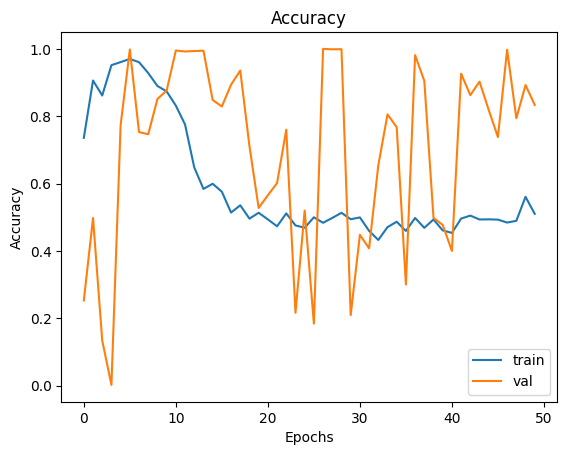

In [20]:
plt.plot(unet_results.history['accuracy'])
plt.plot(unet_results.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','val'])
plt.show()

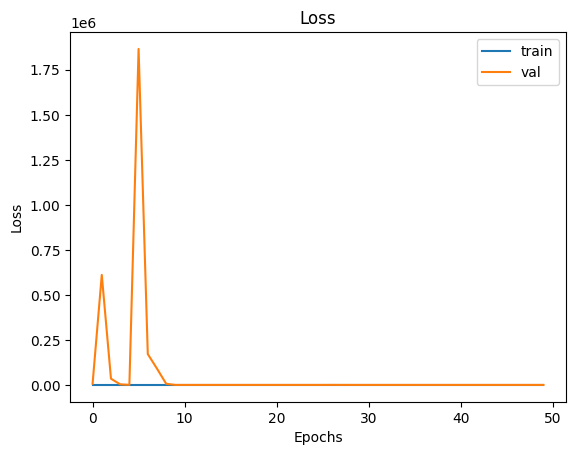

In [21]:
plt.plot(unet_results.history['loss'])
plt.plot(unet_results.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','val'])
plt.show()

# Reload the model

In [23]:
model = load_model('/kaggle/working/unet.h5')

# Inference

In [58]:
def inferencing_model(input_image):
    input_image = cv2.imread(input_image)
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    input_image = cv2.resize(input_image, (512, 512))  

    predictions = model.predict(np.expand_dims(input_image, axis=0))
    
    predicted_classes = np.argmax(predictions[0], axis=-1)  
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    ax[0].imshow(input_image)
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    # Display the class labels
    ax[1].imshow(predicted_classes)  
    ax[1].set_title('Predicted Class Labels')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()


1/1 [==============================] - 0s 25ms/step


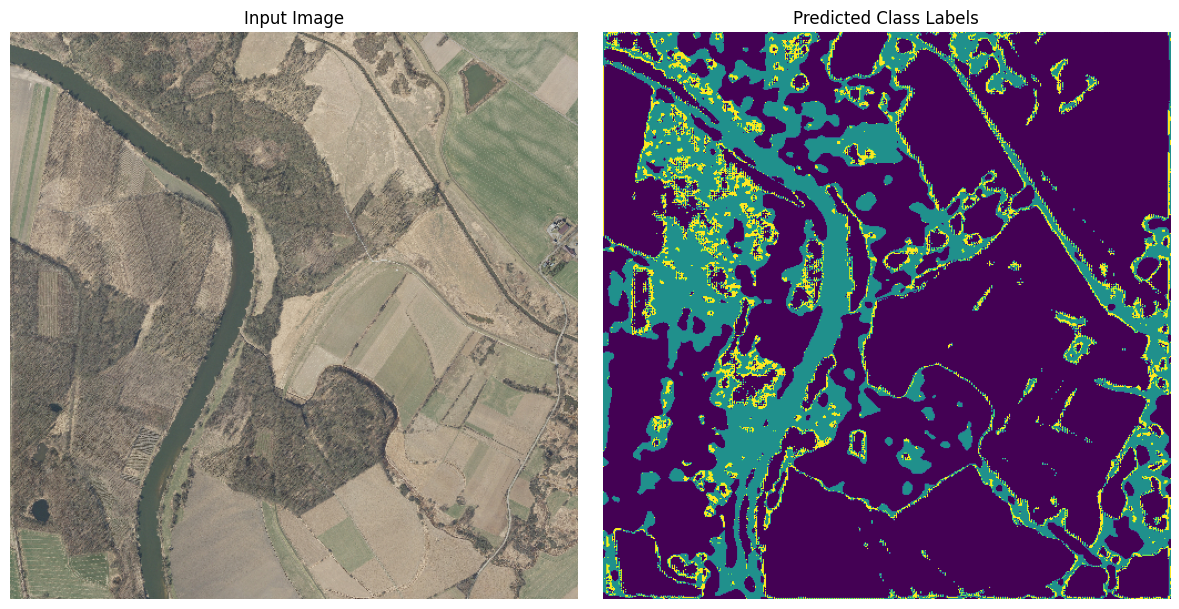

In [59]:
inferencing_model('/kaggle/input/landcoverai/images/M-33-48-A-c-4-4.tif')